## Baseline Model

#### This workbook implements a bag of words model that makes predictions based on word counts, using CountVectorizer. In all instances, these models are essentially as good as guessing, which means they do not have any predictive power.

In [1]:
# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import mixture
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLTK APIs
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


### Load Data

In [2]:
datapath = 'data/fakeNewsDatasets_Perez-Rosas2018'

# Function to load news articles
def tabulate_data(dataset_name):
    """Create a Pandas dataframe out of input Perez-Rosas dataset files
    @param dataset_name: Name of the dataset (fakenews or celebrity)
    @returns Pandas dataframe with columns:
        dataset_name, news_type, news_category, news_headline, news_content
    """
    def remove_numbers(in_str):
        return re.sub(r'[0-9]+', '', in_str)

    result_data_list = []
    data_dir = datapath
    for news_type in ['fake', 'legit']:
        folder = '%s/%s/%s' % (data_dir, dataset_name, news_type)
        for fname in os.listdir(folder):
            result_data = {}
            result_data['dataset_name'] = dataset_name
            result_data['news_type'] = news_type
            if news_type == 'fake':
                result_data['is_fake'] = 1
            else:
                result_data['is_fake'] = 0
            if dataset_name == 'fakeNewsDataset':
                result_data['news_category'] = remove_numbers(fname.split('.')[0])
            result_data['file_name'] = fname
            filepath = os.path.join(folder, fname)
            with open(filepath, 'r', encoding="utf8") as f:
                file_data = f.read().split('\n')
                # Some articles don't have a headline, but only article body.
                if len(file_data) > 1:
                    news_content_data = ' '.join(file_data[2:])
                    result_data['news_headline'] = file_data[0]
                else:
                    news_content_data = file_data[0]
                    result_data['news_headline'] = ''
                result_data['news_content'] = news_content_data
                result_data['news_all'] = ' '.join(file_data[0:])
                result_data_list.append(result_data)
    df = pd.DataFrame(result_data_list)
    return df

In [3]:
# Load fake news data
fakenews_df = tabulate_data('fakeNewsDataset')
fakenews_df.head()

,dataset_name,file_name,is_fake,news_all,news_category,news_content,news_headline,news_type
0,fakeNewsDataset,polit19.fake.txt,1,FBI investigates computer link between Trump a...,polit,(CNN)Federal investigators and computer scie...,FBI investigates computer link between Trump a...,fake
1,fakeNewsDataset,tech028.fake.txt,1,Google steals user location information with a...,tech,Alphabet Inc's Google announced on Wednesday t...,Google steals user location information with a...,fake
2,fakeNewsDataset,polit34.fake.txt,1,"Biden: Trump was wiretapped, but not by US ...",polit,Joe Biden said President Donald Trump was in...,"Biden: Trump was wiretapped, but not by US",fake
3,fakeNewsDataset,edu27.fake.txt,1,"Harvard Law, Moving to Limit Applicant Pool, W...",edu,"Harvard Law School, moving to close its door...","Harvard Law, Moving to Limit Applicant Pool, W...",fake
4,fakeNewsDataset,edu14.fake.txt,1,Microsoft Aims to spread liberalism on the suc...,edu,"With the launch of ""Minecraft"" edition crea...",Microsoft Aims to spread liberalism on the suc...,fake


In [4]:
# Split data into training and test sets
newsVectors, newsVectors_test, classVector, classVector_test = \
    train_test_split(fakenews_df['news_all'],
                     fakenews_df['is_fake'], 
                     test_size = .2,
                     random_state = 1)

## Simple Baseline - without preprocessing

In [18]:
vectorizer = CountVectorizer()
train_data = vectorizer.fit_transform(newsVectors)
test_data = vectorizer.transform(newsVectors_test)

print("Size of the vocabulary:", train_data.shape[1])

Size of the vocabulary: 7259


In [19]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(train_data, classVector)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data, classVector)
multi_clf_best_predicted = multi_clf_best.predict(test_data)
fpr, tpr, _ = metrics.roc_curve(classVector_test, multi_clf_best_predicted)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)
print("Multinomial accuracy: {:2.5f}%".format(accuracy_score(multi_clf_best_predicted, classVector_test) * 100))
print("Multinomial accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(multi_clf_best_predicted))
print('Number predicted as Fake News:',sum(multi_clf_best_predicted))
print('-----------------------------------')
print('--- Confusion Matrix ---')
print(confusion_matrix(classVector_test, multi_clf_best_predicted))

----- Multinomial Naive Bayes -----
{'alpha': 100}
Multinomial accuracy: 41.66667%
Multinomial accuracy (AUC): 50.00000%
Number of predictions: 96
Number predicted as Fake News: 96
-----------------------------------
--- Confusion Matrix ---
[[ 0 56]
 [ 0 40]]


In [20]:
# Logisitc modeling

log_clf = LogisticRegression()
C = {"C": [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(train_data, classVector)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data, classVector)
log_clf_best_predicted = log_clf_best.predict(test_data)
fpr, tpr, _ = metrics.roc_curve(classVector_test, log_clf_best_predicted)
roc_auc = auc(fpr, tpr)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy: {:2.5f}%".format(accuracy_score(log_clf_best_predicted, classVector_test) * 100))
print ("Logistic accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print('--- Confusion Matrix ---')
print (confusion_matrix(classVector_test, log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.04}
Logistic accuracy: 50.00000%
Logistic accuracy (AUC): 50.35714%
--- Confusion Matrix ---
[[27 29]
 [19 21]]
-----------------------------------


## Baseline - with preprocessing

In [ ]:
#nltk.download('stopwords')

In [21]:
# Removing stemming and lemmatization

wnl = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=get_wordnet_pos(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [22]:
# preprocessor

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', 'numseq', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    
    filtered_text = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_text.append(w) 
            
    return filtered_text


### Vectorize Data

In [23]:
vectorizer = CountVectorizer(analyzer=preprocess_text)
train_data = vectorizer.fit_transform(newsVectors)
test_data = vectorizer.transform(newsVectors_test)

print("Size of the vocabulary:", train_data.shape[1])

Size of the vocabulary: 6949


##### Multinomial Naive Bayes Model

In [24]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(train_data, classVector)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data, classVector)
multi_clf_best_predicted = multi_clf_best.predict(test_data)
fpr, tpr, _ = metrics.roc_curve(classVector_test, multi_clf_best_predicted)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)
print("Multinomial accuracy: {:2.5f}%".format(accuracy_score(multi_clf_best_predicted, classVector_test) * 100))
print("Multinomial accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(multi_clf_best_predicted))
print('Number predicted as Fake News:',sum(multi_clf_best_predicted))
print('-----------------------------------')
print('--- Confusion Matrix ---')
print(confusion_matrix(classVector_test, multi_clf_best_predicted))

----- Multinomial Naive Bayes -----
{'alpha': 1000}
Multinomial accuracy: 50.00000%
Multinomial accuracy (AUC): 49.64286%
Number of predictions: 96
Number predicted as Fake News: 46
-----------------------------------
--- Confusion Matrix ---
[[29 27]
 [21 19]]


##### Logistic Regression Model

In [25]:
# Logisitc modeling

log_clf = LogisticRegression()
C = {"C": [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(train_data, classVector)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data, classVector)
log_clf_best_predicted = log_clf_best.predict(test_data)
fpr, tpr, _ = metrics.roc_curve(classVector_test, log_clf_best_predicted)
roc_auc = auc(fpr, tpr)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy: {:2.5f}%".format(accuracy_score(log_clf_best_predicted, classVector_test) * 100))
print ("Logistic accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print('--- Confusion Matrix ---')
print (confusion_matrix(classVector_test, log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 1e-05}
Logistic accuracy: 53.12500%
Logistic accuracy (AUC): 50.17857%
--- Confusion Matrix ---
[[38 18]
 [27 13]]
-----------------------------------


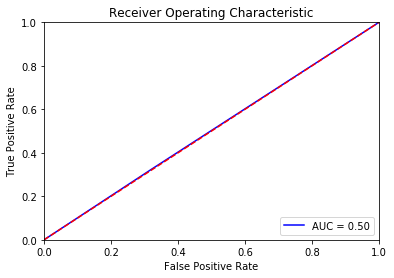

In [26]:
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()